# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import random
import librosa, IPython
import librosa.display as lplt
seed = 12
np.random.seed(seed)

# Loading the Dataset

In [2]:
df = pd.read_csv("final_data.csv")
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


# The Data

In [3]:
print("Dataset has",df.shape)
print("Count of Positive and Negative samples")
df.label.value_counts().reset_index()

Dataset has (9990, 60)
Count of Positive and Negative samples


,index,label
0,pop,1000
1,blues,1000
2,reggae,1000
3,metal,1000
4,jazz,1000
5,disco,999
6,classical,998
7,hiphop,998
8,rock,998
9,country,997


In [4]:
data = df.iloc[0:, 1:]
y = data['label']
X = data.loc[:, data.columns != 'label']

In [5]:
cols = X.columns
min_max_scaler = skp.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)
X = pd.DataFrame(np_scaled, columns = cols)

In [8]:
# map labels to index
label_index = dict()
index_label = dict()
for i, x in enumerate(df.label.unique()):
    label_index[x] = i
    index_label[i] = x
print(label_index)
print(index_label)

{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
{0: 'blues', 1: 'classical', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}


In [9]:
# update labels in df to index
df.label = [label_index[l] for l in df.label]


In [10]:
# shuffle samples
df_shuffle = df.sample(frac=1, random_state=seed).reset_index(drop=True)
# remove irrelevant columns
df_shuffle.drop(['filename', 'length'], axis=1, inplace=True)
df_y = df_shuffle.pop('label')
df_X = df_shuffle

# split into train dev and test
X_train, df_test_valid_X, y_train, df_test_valid_y = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed, stratify=df_y)
X_dev, X_test, y_dev, y_test = skms.train_test_split(df_test_valid_X, df_test_valid_y, train_size=0.66, random_state=seed, stratify=df_test_valid_y)

In [11]:
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Dev set has {X_dev.shape[0]} records out of {len(df_shuffle)} which is {round(X_dev.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 6993 records out of 9990 which is 70%
Dev set has 1978 records out of 9990 which is 20%
Test set has 1019 records out of 9990 which is 10%


In [12]:
scaler = skp.StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_dev = pd.DataFrame(scaler.transform(X_dev), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [13]:
import tensorflow as tf
print("TF version:-", tf.__version__)
import keras as k
tf.random.set_seed(seed)

TF version:- 2.3.0


In [14]:
ACCURACY_THRESHOLD = 0.94

class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

def trainModel(model, epochs, optimizer):
    batch_size = 128
    callback = myCallback()
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy'
    )
    return model.fit(X_train, y_train, validation_data=(X_dev, y_dev), epochs=epochs, 
                     batch_size=batch_size, callbacks=[callback])

def plotHistory(history):
    print("Max. Validation Accuracy",max(history.history["val_accuracy"]))
    pd.DataFrame(history.history).plot(figsize=(12,6))
    plt.show()

In [15]:
model_1 = k.models.Sequential([
    k.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dense(128, activation='relu'),
    k.layers.Dense(64, activation='relu'),
    k.layers.Dense(10, activation='softmax'),
])
print(model_1.summary())
model_1_history = trainModel(model=model_1, epochs=70, optimizer='adam')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               14848     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 56,650
Trainable params: 56,650
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/70
55/55 [==============================] - ETA: 0s - loss: 2.3877 - accuracy: 0.10 - ETA: 0s - loss: 1.9400 - accuracy: 0.33 - ETA: 0s - loss: 1.6062 - accuracy: 0.44 - ETA: 0s - loss: 1.4898 - accuracy: 0.48 - 1s 11ms/step - loss: 1.48

55/55 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 1.00 - ETA: 0s - loss: 0.0194 - accuracy: 0.99 - ETA: 0s - loss: 0.0234 - accuracy: 0.99 - 0s 4ms/step - loss: 0.0413 - accuracy: 0.9888 - val_loss: 0.7936 - val_accuracy: 0.8514
Epoch 67/70
55/55 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.96 - ETA: 0s - loss: 0.1071 - accuracy: 0.96 - ETA: 0s - loss: 0.1076 - accuracy: 0.96 - 0s 3ms/step - loss: 0.1116 - accuracy: 0.9627 - val_loss: 0.7108 - val_accuracy: 0.8534
Epoch 68/70
55/55 [==============================] - ETA: 0s - loss: 0.0954 - accuracy: 0.96 - ETA: 0s - loss: 0.1048 - accuracy: 0.96 - 0s 2ms/step - loss: 0.1016 - accuracy: 0.9661 - val_loss: 0.6417 - val_accuracy: 0.8640
Epoch 69/70
55/55 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.96 - ETA: 0s - loss: 0.0368 - accuracy: 0.98 - 0s 2ms/step - loss: 0.0321 - accuracy: 0.9883 - val_loss: 0.5256 - val_accuracy: 0.8812
Epoch 70/70
55/55 [=========

Max. Validation Accuracy 0.8943377137184143


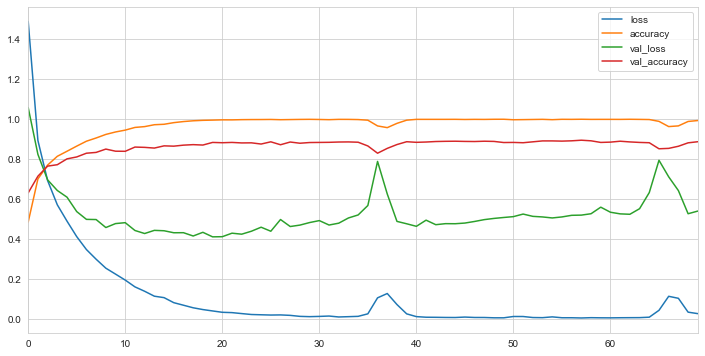

In [16]:
plotHistory(model_1_history)

In [17]:
model_2 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_2.summary())
model_2_history = trainModel(model=model_2, epochs=100, optimizer='adam')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               29696     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

55/55 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.96 - ETA: 0s - loss: 0.0558 - accuracy: 0.98 - ETA: 0s - loss: 0.0609 - accuracy: 0.98 - ETA: 0s - loss: 0.0627 - accuracy: 0.98 - ETA: 0s - loss: 0.0668 - accuracy: 0.97 - 0s 5ms/step - loss: 0.0665 - accuracy: 0.9793 - val_loss: 0.3484 - val_accuracy: 0.9090
Epoch 43/100
55/55 [==============================] - ETA: 0s - loss: 0.0451 - accuracy: 0.96 - ETA: 0s - loss: 0.0760 - accuracy: 0.97 - ETA: 0s - loss: 0.0592 - accuracy: 0.97 - ETA: 0s - loss: 0.0568 - accuracy: 0.97 - ETA: 0s - loss: 0.0643 - accuracy: 0.97 - 0s 5ms/step - loss: 0.0625 - accuracy: 0.9781 - val_loss: 0.3401 - val_accuracy: 0.9171
Epoch 44/100
55/55 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.98 - ETA: 0s - loss: 0.0742 - accuracy: 0.97 - ETA: 0s - loss: 0.0741 - accuracy: 0.97 - ETA: 0s - loss: 0.0776 - accuracy: 0.97 - ETA: 0s - loss: 0.0755 - accuracy: 0.97 - 0s 5ms/step - loss: 0.0767 - accuracy: 0.9750

Epoch 66/100
55/55 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.99 - ETA: 0s - loss: 0.0428 - accuracy: 0.98 - ETA: 0s - loss: 0.0493 - accuracy: 0.98 - ETA: 0s - loss: 0.0511 - accuracy: 0.98 - 0s 4ms/step - loss: 0.0498 - accuracy: 0.9836 - val_loss: 0.3761 - val_accuracy: 0.9186
Epoch 67/100
55/55 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.98 - ETA: 0s - loss: 0.0344 - accuracy: 0.98 - ETA: 0s - loss: 0.0330 - accuracy: 0.98 - ETA: 0s - loss: 0.0375 - accuracy: 0.98 - 0s 4ms/step - loss: 0.0404 - accuracy: 0.9868 - val_loss: 0.3676 - val_accuracy: 0.9191
Epoch 68/100
55/55 [==============================] - ETA: 0s - loss: 0.0241 - accuracy: 0.99 - ETA: 0s - loss: 0.0368 - accuracy: 0.98 - ETA: 0s - loss: 0.0442 - accuracy: 0.98 - ETA: 0s - loss: 0.0454 - accuracy: 0.98 - 0s 4ms/step - loss: 0.0456 - accuracy: 0.9856 - val_loss: 0.3655 - val_accuracy: 0.9211
Epoch 69/100
55/55 [==============================] - ETA: 0s - loss: 

Epoch 92/100
55/55 [==============================] - ETA: 0s - loss: 0.0085 - accuracy: 1.00 - ETA: 0s - loss: 0.0222 - accuracy: 0.99 - ETA: 0s - loss: 0.0209 - accuracy: 0.99 - ETA: 0s - loss: 0.0231 - accuracy: 0.99 - 0s 4ms/step - loss: 0.0254 - accuracy: 0.9924 - val_loss: 0.4075 - val_accuracy: 0.9161
Epoch 93/100
55/55 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 1.00 - ETA: 0s - loss: 0.0523 - accuracy: 0.98 - ETA: 0s - loss: 0.0554 - accuracy: 0.98 - ETA: 0s - loss: 0.0504 - accuracy: 0.98 - 0s 4ms/step - loss: 0.0522 - accuracy: 0.9870 - val_loss: 0.3241 - val_accuracy: 0.9242
Epoch 94/100
55/55 [==============================] - ETA: 0s - loss: 0.0415 - accuracy: 0.99 - ETA: 0s - loss: 0.0377 - accuracy: 0.98 - ETA: 0s - loss: 0.0342 - accuracy: 0.99 - ETA: 0s - loss: 0.0327 - accuracy: 0.99 - 0s 4ms/step - loss: 0.0321 - accuracy: 0.9900 - val_loss: 0.3775 - val_accuracy: 0.9232
Epoch 95/100
55/55 [==============================] - ETA: 0s - loss: 

Max. Validation Accuracy 0.9256824851036072


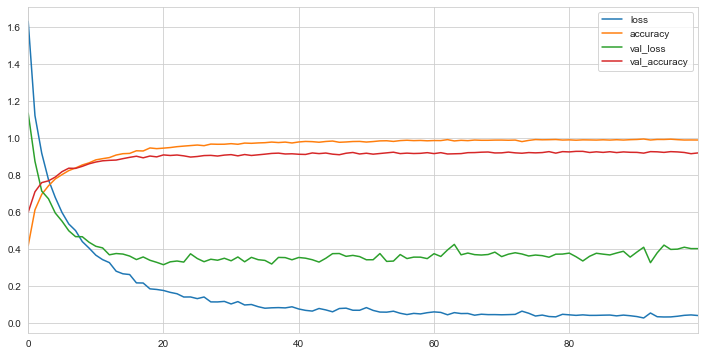

In [18]:
plotHistory(model_2_history)

In [19]:
model_3 = k.models.Sequential([
    k.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.2),
    
    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.2),

    k.layers.Dense(10, activation='softmax'),
])
print(model_3.summary())
model_3_history = trainModel(model=model_3, epochs=700, optimizer='sgd')

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               29696     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)               

55/55 [==============================] - ETA: 0s - loss: 0.9746 - accuracy: 0.67 - ETA: 0s - loss: 0.9261 - accuracy: 0.68 - ETA: 0s - loss: 0.8998 - accuracy: 0.69 - ETA: 0s - loss: 0.8971 - accuracy: 0.69 - 0s 4ms/step - loss: 0.9000 - accuracy: 0.6961 - val_loss: 0.7875 - val_accuracy: 0.7280
Epoch 49/700
55/55 [==============================] - ETA: 0s - loss: 0.9133 - accuracy: 0.65 - ETA: 0s - loss: 0.8741 - accuracy: 0.70 - ETA: 0s - loss: 0.8882 - accuracy: 0.69 - ETA: 0s - loss: 0.8889 - accuracy: 0.69 - 0s 4ms/step - loss: 0.8912 - accuracy: 0.6934 - val_loss: 0.7810 - val_accuracy: 0.7300
Epoch 50/700
55/55 [==============================] - ETA: 0s - loss: 0.8858 - accuracy: 0.69 - ETA: 0s - loss: 0.9035 - accuracy: 0.68 - ETA: 0s - loss: 0.8904 - accuracy: 0.69 - ETA: 0s - loss: 0.8857 - accuracy: 0.69 - 0s 4ms/step - loss: 0.8863 - accuracy: 0.6966 - val_loss: 0.7771 - val_accuracy: 0.7300
Epoch 51/700
55/55 [==============================] - ETA: 0s - loss: 1.1974 - accu

55/55 [==============================] - ETA: 0s - loss: 0.6070 - accuracy: 0.77 - ETA: 0s - loss: 0.5991 - accuracy: 0.80 - ETA: 0s - loss: 0.5994 - accuracy: 0.80 - ETA: 0s - loss: 0.6050 - accuracy: 0.79 - 0s 5ms/step - loss: 0.6061 - accuracy: 0.7967 - val_loss: 0.5606 - val_accuracy: 0.8089
Epoch 100/700
55/55 [==============================] - ETA: 0s - loss: 0.6644 - accuracy: 0.78 - ETA: 0s - loss: 0.6176 - accuracy: 0.79 - ETA: 0s - loss: 0.6334 - accuracy: 0.78 - ETA: 0s - loss: 0.6192 - accuracy: 0.78 - ETA: 0s - loss: 0.6185 - accuracy: 0.79 - 0s 5ms/step - loss: 0.6176 - accuracy: 0.7902 - val_loss: 0.5596 - val_accuracy: 0.8089
Epoch 101/700
55/55 [==============================] - ETA: 0s - loss: 0.5418 - accuracy: 0.79 - ETA: 0s - loss: 0.5681 - accuracy: 0.81 - ETA: 0s - loss: 0.5759 - accuracy: 0.81 - ETA: 0s - loss: 0.5948 - accuracy: 0.80 - ETA: 0s - loss: 0.5930 - accuracy: 0.80 - 0s 5ms/step - loss: 0.5939 - accuracy: 0.8062 - val_loss: 0.5549 - val_accuracy: 0.80

55/55 [==============================] - ETA: 0s - loss: 0.4176 - accuracy: 0.85 - ETA: 0s - loss: 0.4072 - accuracy: 0.86 - ETA: 0s - loss: 0.4091 - accuracy: 0.86 - ETA: 0s - loss: 0.4177 - accuracy: 0.86 - 0s 5ms/step - loss: 0.4236 - accuracy: 0.8569 - val_loss: 0.4435 - val_accuracy: 0.8559
Epoch 151/700
55/55 [==============================] - ETA: 0s - loss: 0.5063 - accuracy: 0.81 - ETA: 0s - loss: 0.4379 - accuracy: 0.85 - ETA: 0s - loss: 0.4229 - accuracy: 0.85 - ETA: 0s - loss: 0.4221 - accuracy: 0.85 - ETA: 0s - loss: 0.4307 - accuracy: 0.85 - 0s 5ms/step - loss: 0.4284 - accuracy: 0.8563 - val_loss: 0.4416 - val_accuracy: 0.8554
Epoch 152/700
55/55 [==============================] - ETA: 0s - loss: 0.4371 - accuracy: 0.85 - ETA: 0s - loss: 0.4261 - accuracy: 0.85 - ETA: 0s - loss: 0.4227 - accuracy: 0.85 - ETA: 0s - loss: 0.4184 - accuracy: 0.86 - ETA: 0s - loss: 0.4241 - accuracy: 0.85 - 0s 5ms/step - loss: 0.4214 - accuracy: 0.8591 - val_loss: 0.4401 - val_accuracy: 0.86

Epoch 201/700
55/55 [==============================] - ETA: 0s - loss: 0.3268 - accuracy: 0.86 - ETA: 0s - loss: 0.2965 - accuracy: 0.89 - ETA: 0s - loss: 0.3102 - accuracy: 0.89 - ETA: 0s - loss: 0.3060 - accuracy: 0.89 - ETA: 0s - loss: 0.3077 - accuracy: 0.89 - 0s 5ms/step - loss: 0.3079 - accuracy: 0.8979 - val_loss: 0.3698 - val_accuracy: 0.8807
Epoch 202/700
55/55 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.93 - ETA: 0s - loss: 0.3090 - accuracy: 0.88 - ETA: 0s - loss: 0.3117 - accuracy: 0.89 - ETA: 0s - loss: 0.3158 - accuracy: 0.89 - 0s 5ms/step - loss: 0.3123 - accuracy: 0.8979 - val_loss: 0.3675 - val_accuracy: 0.8827
Epoch 203/700
55/55 [==============================] - ETA: 0s - loss: 0.3281 - accuracy: 0.89 - ETA: 0s - loss: 0.3029 - accuracy: 0.90 - ETA: 0s - loss: 0.2936 - accuracy: 0.90 - ETA: 0s - loss: 0.2971 - accuracy: 0.90 - 0s 5ms/step - loss: 0.3051 - accuracy: 0.8979 - val_loss: 0.3714 - val_accuracy: 0.8812
Epoch 204/700
55/55 [====

Epoch 253/700
55/55 [==============================] - ETA: 0s - loss: 0.2287 - accuracy: 0.90 - ETA: 0s - loss: 0.2221 - accuracy: 0.92 - ETA: 0s - loss: 0.2243 - accuracy: 0.92 - ETA: 0s - loss: 0.2144 - accuracy: 0.93 - 0s 4ms/step - loss: 0.2224 - accuracy: 0.9285 - val_loss: 0.3369 - val_accuracy: 0.8923
Epoch 254/700
55/55 [==============================] - ETA: 0s - loss: 0.2090 - accuracy: 0.91 - ETA: 0s - loss: 0.2320 - accuracy: 0.91 - ETA: 0s - loss: 0.2230 - accuracy: 0.92 - ETA: 0s - loss: 0.2226 - accuracy: 0.92 - ETA: 0s - loss: 0.2268 - accuracy: 0.92 - 0s 5ms/step - loss: 0.2268 - accuracy: 0.9248 - val_loss: 0.3369 - val_accuracy: 0.8913
Epoch 255/700
55/55 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.92 - ETA: 0s - loss: 0.2208 - accuracy: 0.92 - ETA: 0s - loss: 0.2283 - accuracy: 0.92 - ETA: 0s - loss: 0.2262 - accuracy: 0.92 - ETA: 0s - loss: 0.2189 - accuracy: 0.92 - 0s 5ms/step - loss: 0.2192 - accuracy: 0.9262 - val_loss: 0.3338 - val_

Epoch 303/700
55/55 [==============================] - ETA: 0s - loss: 0.1303 - accuracy: 0.96 - ETA: 0s - loss: 0.1589 - accuracy: 0.95 - ETA: 0s - loss: 0.1648 - accuracy: 0.95 - ETA: 0s - loss: 0.1604 - accuracy: 0.95 - 0s 5ms/step - loss: 0.1640 - accuracy: 0.9505 - val_loss: 0.3225 - val_accuracy: 0.9080
Epoch 304/700
55/55 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.96 - ETA: 0s - loss: 0.1548 - accuracy: 0.94 - ETA: 0s - loss: 0.1662 - accuracy: 0.94 - ETA: 0s - loss: 0.1680 - accuracy: 0.94 - 0s 5ms/step - loss: 0.1667 - accuracy: 0.9467 - val_loss: 0.3210 - val_accuracy: 0.9050
Epoch 305/700
55/55 [==============================] - ETA: 0s - loss: 0.1616 - accuracy: 0.94 - ETA: 0s - loss: 0.1661 - accuracy: 0.94 - ETA: 0s - loss: 0.1660 - accuracy: 0.94 - ETA: 0s - loss: 0.1657 - accuracy: 0.94 - 0s 4ms/step - loss: 0.1616 - accuracy: 0.9479 - val_loss: 0.3245 - val_accuracy: 0.9055
Epoch 306/700
55/55 [==============================] - ETA: 0s - lo

55/55 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.96 - ETA: 0s - loss: 0.1208 - accuracy: 0.96 - ETA: 0s - loss: 0.1302 - accuracy: 0.96 - ETA: 0s - loss: 0.1320 - accuracy: 0.95 - ETA: 0s - loss: 0.1335 - accuracy: 0.95 - 0s 4ms/step - loss: 0.1335 - accuracy: 0.9577 - val_loss: 0.3141 - val_accuracy: 0.9034
Epoch 353/700
55/55 [==============================] - ETA: 0s - loss: 0.1008 - accuracy: 0.96 - ETA: 0s - loss: 0.1151 - accuracy: 0.96 - ETA: 0s - loss: 0.1354 - accuracy: 0.95 - ETA: 0s - loss: 0.1337 - accuracy: 0.95 - 0s 4ms/step - loss: 0.1347 - accuracy: 0.9558 - val_loss: 0.3154 - val_accuracy: 0.9075
Epoch 354/700
55/55 [==============================] - ETA: 0s - loss: 0.0986 - accuracy: 0.96 - ETA: 0s - loss: 0.1429 - accuracy: 0.95 - ETA: 0s - loss: 0.1473 - accuracy: 0.95 - ETA: 0s - loss: 0.1424 - accuracy: 0.95 - ETA: 0s - loss: 0.1361 - accuracy: 0.95 - 0s 5ms/step - loss: 0.1369 - accuracy: 0.9557 - val_loss: 0.3136 - val_accuracy: 0.90

Epoch 401/700
55/55 [==============================] - ETA: 0s - loss: 0.0672 - accuracy: 0.97 - ETA: 0s - loss: 0.0983 - accuracy: 0.97 - ETA: 0s - loss: 0.1029 - accuracy: 0.96 - ETA: 0s - loss: 0.1027 - accuracy: 0.96 - 0s 4ms/step - loss: 0.1017 - accuracy: 0.9663 - val_loss: 0.3133 - val_accuracy: 0.9060
Epoch 402/700
55/55 [==============================] - ETA: 0s - loss: 0.0859 - accuracy: 0.96 - ETA: 0s - loss: 0.1072 - accuracy: 0.96 - ETA: 0s - loss: 0.1009 - accuracy: 0.96 - ETA: 0s - loss: 0.1023 - accuracy: 0.96 - ETA: 0s - loss: 0.1043 - accuracy: 0.96 - 0s 5ms/step - loss: 0.1046 - accuracy: 0.9621 - val_loss: 0.3151 - val_accuracy: 0.9095
Epoch 403/700
55/55 [==============================] - ETA: 0s - loss: 0.0790 - accuracy: 0.98 - ETA: 0s - loss: 0.1092 - accuracy: 0.96 - ETA: 0s - loss: 0.1085 - accuracy: 0.96 - ETA: 0s - loss: 0.1159 - accuracy: 0.96 - ETA: 0s - loss: 0.1154 - accuracy: 0.96 - 0s 5ms/step - loss: 0.1111 - accuracy: 0.9648 - val_loss: 0.3110 - val_

Epoch 426/700
55/55 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.96 - ETA: 0s - loss: 0.0874 - accuracy: 0.96 - ETA: 0s - loss: 0.0941 - accuracy: 0.96 - ETA: 0s - loss: 0.0940 - accuracy: 0.96 - ETA: 0s - loss: 0.0957 - accuracy: 0.96 - 0s 5ms/step - loss: 0.0992 - accuracy: 0.9677 - val_loss: 0.3130 - val_accuracy: 0.9100
Epoch 427/700
55/55 [==============================] - ETA: 0s - loss: 0.0731 - accuracy: 0.97 - ETA: 0s - loss: 0.0933 - accuracy: 0.97 - ETA: 0s - loss: 0.0878 - accuracy: 0.97 - ETA: 0s - loss: 0.0926 - accuracy: 0.97 - 0s 4ms/step - loss: 0.0929 - accuracy: 0.9720 - val_loss: 0.3180 - val_accuracy: 0.9085
Epoch 428/700
55/55 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.98 - ETA: 0s - loss: 0.0841 - accuracy: 0.97 - ETA: 0s - loss: 0.0901 - accuracy: 0.97 - ETA: 0s - loss: 0.0889 - accuracy: 0.97 - ETA: 0s - loss: 0.0917 - accuracy: 0.97 - 0s 5ms/step - loss: 0.0919 - accuracy: 0.9711 - val_loss: 0.3203 - val_

Epoch 472/700
55/55 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.98 - ETA: 0s - loss: 0.0659 - accuracy: 0.98 - ETA: 0s - loss: 0.0738 - accuracy: 0.97 - ETA: 0s - loss: 0.0759 - accuracy: 0.97 - ETA: 0s - loss: 0.0812 - accuracy: 0.97 - 0s 5ms/step - loss: 0.0808 - accuracy: 0.9747 - val_loss: 0.3122 - val_accuracy: 0.9085
Epoch 473/700
55/55 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.99 - ETA: 0s - loss: 0.0828 - accuracy: 0.97 - ETA: 0s - loss: 0.0818 - accuracy: 0.97 - ETA: 0s - loss: 0.0832 - accuracy: 0.97 - ETA: 0s - loss: 0.0811 - accuracy: 0.97 - 0s 4ms/step - loss: 0.0811 - accuracy: 0.9745 - val_loss: 0.3156 - val_accuracy: 0.9085
Epoch 474/700
55/55 [==============================] - ETA: 0s - loss: 0.0525 - accuracy: 0.99 - ETA: 0s - loss: 0.0896 - accuracy: 0.97 - ETA: 0s - loss: 0.0929 - accuracy: 0.97 - ETA: 0s - loss: 0.0880 - accuracy: 0.97 - ETA: 0s - loss: 0.0833 - accuracy: 0.97 - 0s 4ms/step - loss: 0.0834 - 

55/55 [==============================] - ETA: 0s - loss: 0.0808 - accuracy: 0.96 - ETA: 0s - loss: 0.0607 - accuracy: 0.97 - ETA: 0s - loss: 0.0582 - accuracy: 0.98 - ETA: 0s - loss: 0.0585 - accuracy: 0.98 - ETA: 0s - loss: 0.0595 - accuracy: 0.98 - 0s 5ms/step - loss: 0.0596 - accuracy: 0.9811 - val_loss: 0.3213 - val_accuracy: 0.9075
Epoch 519/700
55/55 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.97 - ETA: 0s - loss: 0.0673 - accuracy: 0.97 - ETA: 0s - loss: 0.0677 - accuracy: 0.97 - ETA: 0s - loss: 0.0655 - accuracy: 0.97 - ETA: 0s - loss: 0.0680 - accuracy: 0.98 - 0s 5ms/step - loss: 0.0687 - accuracy: 0.9801 - val_loss: 0.3244 - val_accuracy: 0.9100
Epoch 520/700
55/55 [==============================] - ETA: 0s - loss: 0.0264 - accuracy: 1.00 - ETA: 0s - loss: 0.0710 - accuracy: 0.97 - ETA: 0s - loss: 0.0700 - accuracy: 0.97 - ETA: 0s - loss: 0.0659 - accuracy: 0.98 - ETA: 0s - loss: 0.0673 - accuracy: 0.97 - 0s 5ms/step - loss: 0.0672 - accuracy: 0.97

55/55 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.98 - ETA: 0s - loss: 0.0554 - accuracy: 0.98 - ETA: 0s - loss: 0.0607 - accuracy: 0.97 - ETA: 0s - loss: 0.0591 - accuracy: 0.97 - ETA: 0s - loss: 0.0630 - accuracy: 0.97 - 0s 5ms/step - loss: 0.0631 - accuracy: 0.9787 - val_loss: 0.3237 - val_accuracy: 0.9135
Epoch 565/700
55/55 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.98 - ETA: 0s - loss: 0.0639 - accuracy: 0.97 - ETA: 0s - loss: 0.0634 - accuracy: 0.97 - ETA: 0s - loss: 0.0638 - accuracy: 0.97 - ETA: 0s - loss: 0.0649 - accuracy: 0.98 - 0s 5ms/step - loss: 0.0649 - accuracy: 0.9800 - val_loss: 0.3191 - val_accuracy: 0.9130
Epoch 566/700
55/55 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.98 - ETA: 0s - loss: 0.0673 - accuracy: 0.97 - ETA: 0s - loss: 0.0612 - accuracy: 0.97 - ETA: 0s - loss: 0.0612 - accuracy: 0.97 - ETA: 0s - loss: 0.0588 - accuracy: 0.98 - 0s 5ms/step - loss: 0.0584 - accuracy: 0.98

55/55 [==============================] - ETA: 0s - loss: 0.0263 - accuracy: 1.00 - ETA: 0s - loss: 0.0439 - accuracy: 0.98 - ETA: 0s - loss: 0.0429 - accuracy: 0.98 - ETA: 0s - loss: 0.0476 - accuracy: 0.98 - ETA: 0s - loss: 0.0501 - accuracy: 0.98 - 0s 5ms/step - loss: 0.0501 - accuracy: 0.9847 - val_loss: 0.3355 - val_accuracy: 0.9125
Epoch 611/700
55/55 [==============================] - ETA: 0s - loss: 0.0938 - accuracy: 0.98 - ETA: 0s - loss: 0.0575 - accuracy: 0.97 - ETA: 0s - loss: 0.0569 - accuracy: 0.98 - ETA: 0s - loss: 0.0534 - accuracy: 0.98 - ETA: 0s - loss: 0.0501 - accuracy: 0.98 - 0s 5ms/step - loss: 0.0513 - accuracy: 0.9846 - val_loss: 0.3272 - val_accuracy: 0.9141
Epoch 612/700
55/55 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 1.00 - ETA: 0s - loss: 0.0409 - accuracy: 0.98 - ETA: 0s - loss: 0.0527 - accuracy: 0.98 - ETA: 0s - loss: 0.0556 - accuracy: 0.98 - ETA: 0s - loss: 0.0540 - accuracy: 0.98 - 0s 5ms/step - loss: 0.0544 - accuracy: 0.98

Epoch 634/700
55/55 [==============================] - ETA: 0s - loss: 0.0363 - accuracy: 0.98 - ETA: 0s - loss: 0.0557 - accuracy: 0.98 - ETA: 0s - loss: 0.0536 - accuracy: 0.98 - ETA: 0s - loss: 0.0522 - accuracy: 0.98 - 0s 4ms/step - loss: 0.0511 - accuracy: 0.9847 - val_loss: 0.3320 - val_accuracy: 0.9196
Epoch 635/700
55/55 [==============================] - ETA: 0s - loss: 0.0645 - accuracy: 0.99 - ETA: 0s - loss: 0.0510 - accuracy: 0.98 - ETA: 0s - loss: 0.0523 - accuracy: 0.98 - ETA: 0s - loss: 0.0502 - accuracy: 0.98 - ETA: 0s - loss: 0.0491 - accuracy: 0.98 - 0s 5ms/step - loss: 0.0491 - accuracy: 0.9841 - val_loss: 0.3333 - val_accuracy: 0.9171
Epoch 636/700
55/55 [==============================] - ETA: 0s - loss: 0.0277 - accuracy: 0.98 - ETA: 0s - loss: 0.0408 - accuracy: 0.98 - ETA: 0s - loss: 0.0458 - accuracy: 0.98 - ETA: 0s - loss: 0.0465 - accuracy: 0.98 - ETA: 0s - loss: 0.0501 - accuracy: 0.98 - 0s 5ms/step - loss: 0.0510 - accuracy: 0.9827 - val_loss: 0.3280 - val_

Epoch 679/700
55/55 [==============================] - ETA: 0s - loss: 0.0784 - accuracy: 0.96 - ETA: 0s - loss: 0.0504 - accuracy: 0.98 - ETA: 0s - loss: 0.0441 - accuracy: 0.98 - ETA: 0s - loss: 0.0432 - accuracy: 0.98 - ETA: 0s - loss: 0.0426 - accuracy: 0.98 - ETA: 0s - loss: 0.0428 - accuracy: 0.98 - 0s 6ms/step - loss: 0.0437 - accuracy: 0.9858 - val_loss: 0.3346 - val_accuracy: 0.9135
Epoch 680/700
55/55 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.98 - ETA: 0s - loss: 0.0480 - accuracy: 0.98 - ETA: 0s - loss: 0.0509 - accuracy: 0.98 - ETA: 0s - loss: 0.0514 - accuracy: 0.98 - ETA: 0s - loss: 0.0501 - accuracy: 0.98 - ETA: 0s - loss: 0.0510 - accuracy: 0.98 - 0s 6ms/step - loss: 0.0514 - accuracy: 0.9823 - val_loss: 0.3393 - val_accuracy: 0.9125
Epoch 681/700
55/55 [==============================] - ETA: 0s - loss: 0.0253 - accuracy: 0.98 - ETA: 0s - loss: 0.0450 - accuracy: 0.98 - ETA: 0s - loss: 0.0412 - accuracy: 0.98 - ETA: 0s - loss: 0.0421 - accu

Max. Validation Accuracy 0.9196157455444336


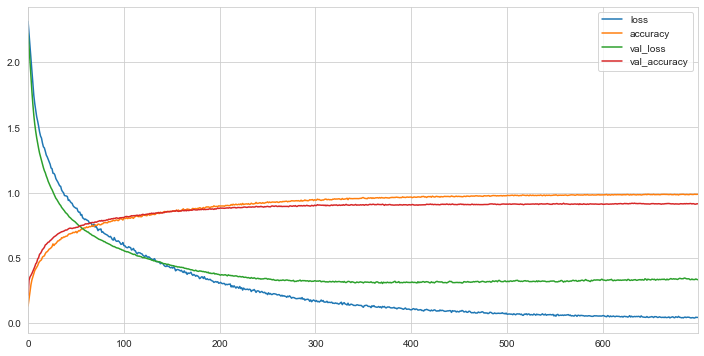

In [20]:
plotHistory(model_3_history)

In [21]:
model_4 = k.models.Sequential([
    k.layers.Dense(1024, activation='relu', input_shape=(X_train.shape[1],)),
    k.layers.Dropout(0.3),
    
    k.layers.Dense(512, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(256, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(128, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(64, activation='relu'),
    k.layers.Dropout(0.3),

    k.layers.Dense(10, activation='softmax'),
])
print(model_4.summary())
model_4_history = trainModel(model=model_4, epochs=500, optimizer='rmsprop')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 1024)              59392     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)              

55/55 [==============================] - ETA: 0s - loss: 0.2595 - accuracy: 0.91 - ETA: 0s - loss: 0.2639 - accuracy: 0.91 - ETA: 0s - loss: 0.2401 - accuracy: 0.92 - ETA: 0s - loss: 0.2355 - accuracy: 0.92 - ETA: 0s - loss: 0.2345 - accuracy: 0.92 - ETA: 0s - loss: 0.2268 - accuracy: 0.92 - ETA: 0s - loss: 0.2186 - accuracy: 0.92 - ETA: 0s - loss: 0.2244 - accuracy: 0.92 - ETA: 0s - loss: 0.2365 - accuracy: 0.92 - ETA: 0s - loss: 0.2418 - accuracy: 0.92 - ETA: 0s - loss: 0.2437 - accuracy: 0.92 - ETA: 0s - loss: 0.2510 - accuracy: 0.92 - ETA: 0s - loss: 0.2628 - accuracy: 0.91 - ETA: 0s - loss: 0.2600 - accuracy: 0.91 - ETA: 0s - loss: 0.2652 - accuracy: 0.91 - 1s 16ms/step - loss: 0.2651 - accuracy: 0.9155 - val_loss: 0.4463 - val_accuracy: 0.8761
Epoch 18/500
55/55 [==============================] - ETA: 0s - loss: 0.1588 - accuracy: 0.95 - ETA: 0s - loss: 0.2668 - accuracy: 0.91 - ETA: 0s - loss: 0.3094 - accuracy: 0.90 - ETA: 0s - loss: 0.2730 - accuracy: 0.91 - ETA: 0s - loss: 0.

55/55 [==============================] - ETA: 0s - loss: 0.1104 - accuracy: 0.96 - ETA: 0s - loss: 0.1224 - accuracy: 0.96 - ETA: 0s - loss: 0.1370 - accuracy: 0.96 - ETA: 0s - loss: 0.1544 - accuracy: 0.95 - ETA: 0s - loss: 0.1537 - accuracy: 0.95 - ETA: 0s - loss: 0.1370 - accuracy: 0.96 - ETA: 0s - loss: 0.1370 - accuracy: 0.96 - ETA: 0s - loss: 0.1330 - accuracy: 0.96 - ETA: 0s - loss: 0.1282 - accuracy: 0.96 - ETA: 0s - loss: 0.1278 - accuracy: 0.96 - ETA: 0s - loss: 0.1223 - accuracy: 0.96 - ETA: 0s - loss: 0.1271 - accuracy: 0.96 - ETA: 0s - loss: 0.1373 - accuracy: 0.96 - ETA: 0s - loss: 0.1323 - accuracy: 0.96 - ETA: 0s - loss: 0.1322 - accuracy: 0.96 - ETA: 0s - loss: 0.1331 - accuracy: 0.96 - ETA: 0s - loss: 0.1292 - accuracy: 0.96 - ETA: 0s - loss: 0.1280 - accuracy: 0.96 - 1s 20ms/step - loss: 0.1278 - accuracy: 0.9661 - val_loss: 0.4348 - val_accuracy: 0.9080
Epoch 38/500
55/55 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.94 - ETA: 0s - loss: 0.

55/55 [==============================] - ETA: 0s - loss: 0.0688 - accuracy: 0.97 - ETA: 0s - loss: 0.0918 - accuracy: 0.97 - ETA: 0s - loss: 0.0873 - accuracy: 0.97 - ETA: 0s - loss: 0.0802 - accuracy: 0.97 - ETA: 0s - loss: 0.0787 - accuracy: 0.97 - ETA: 0s - loss: 0.0800 - accuracy: 0.97 - ETA: 0s - loss: 0.0786 - accuracy: 0.97 - ETA: 0s - loss: 0.0801 - accuracy: 0.97 - ETA: 0s - loss: 0.0773 - accuracy: 0.97 - ETA: 0s - loss: 0.0812 - accuracy: 0.97 - ETA: 0s - loss: 0.0845 - accuracy: 0.97 - ETA: 0s - loss: 0.0881 - accuracy: 0.97 - ETA: 0s - loss: 0.0949 - accuracy: 0.97 - ETA: 0s - loss: 0.0928 - accuracy: 0.97 - 1s 16ms/step - loss: 0.0938 - accuracy: 0.9743 - val_loss: 0.3982 - val_accuracy: 0.9171
Epoch 58/500
55/55 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.99 - ETA: 0s - loss: 0.0581 - accuracy: 0.98 - ETA: 0s - loss: 0.0439 - accuracy: 0.98 - ETA: 0s - loss: 0.0671 - accuracy: 0.98 - ETA: 0s - loss: 0.0728 - accuracy: 0.97 - ETA: 0s - loss: 0.

55/55 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 0.99 - ETA: 0s - loss: 0.0476 - accuracy: 0.98 - ETA: 0s - loss: 0.0387 - accuracy: 0.98 - ETA: 0s - loss: 0.0544 - accuracy: 0.98 - ETA: 0s - loss: 0.0492 - accuracy: 0.98 - ETA: 0s - loss: 0.0626 - accuracy: 0.98 - ETA: 0s - loss: 0.0600 - accuracy: 0.98 - ETA: 0s - loss: 0.0651 - accuracy: 0.98 - ETA: 0s - loss: 0.0674 - accuracy: 0.98 - ETA: 0s - loss: 0.0757 - accuracy: 0.98 - ETA: 0s - loss: 0.0754 - accuracy: 0.98 - ETA: 0s - loss: 0.0721 - accuracy: 0.98 - ETA: 0s - loss: 0.0720 - accuracy: 0.98 - ETA: 0s - loss: 0.0688 - accuracy: 0.98 - ETA: 0s - loss: 0.0707 - accuracy: 0.98 - 1s 16ms/step - loss: 0.0704 - accuracy: 0.9826 - val_loss: 0.4593 - val_accuracy: 0.9287
Epoch 78/500
55/55 [==============================] - ETA: 0s - loss: 0.0410 - accuracy: 0.98 - ETA: 0s - loss: 0.0875 - accuracy: 0.98 - ETA: 0s - loss: 0.0770 - accuracy: 0.98 - ETA: 0s - loss: 0.0806 - accuracy: 0.98 - ETA: 0s - loss: 0.

Epoch 88/500
55/55 [==============================] - ETA: 0s - loss: 0.0789 - accuracy: 0.97 - ETA: 0s - loss: 0.0470 - accuracy: 0.98 - ETA: 0s - loss: 0.0654 - accuracy: 0.98 - ETA: 0s - loss: 0.0568 - accuracy: 0.98 - ETA: 0s - loss: 0.0668 - accuracy: 0.98 - ETA: 0s - loss: 0.0576 - accuracy: 0.98 - ETA: 0s - loss: 0.0547 - accuracy: 0.98 - ETA: 0s - loss: 0.0504 - accuracy: 0.98 - ETA: 0s - loss: 0.0524 - accuracy: 0.98 - ETA: 0s - loss: 0.0524 - accuracy: 0.98 - ETA: 0s - loss: 0.0575 - accuracy: 0.98 - ETA: 0s - loss: 0.0695 - accuracy: 0.98 - ETA: 0s - loss: 0.0660 - accuracy: 0.98 - ETA: 0s - loss: 0.0699 - accuracy: 0.98 - ETA: 0s - loss: 0.0706 - accuracy: 0.98 - ETA: 0s - loss: 0.0723 - accuracy: 0.98 - 1s 18ms/step - loss: 0.0740 - accuracy: 0.9844 - val_loss: 0.5510 - val_accuracy: 0.9292
Epoch 89/500
55/55 [==============================] - ETA: 0s - loss: 0.1152 - accuracy: 0.97 - ETA: 0s - loss: 0.0909 - accuracy: 0.97 - ETA: 0s - loss: 0.0917 - accuracy: 0.98 - ETA: 

55/55 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 0.98 - ETA: 0s - loss: 0.0766 - accuracy: 0.98 - ETA: 0s - loss: 0.0721 - accuracy: 0.98 - ETA: 0s - loss: 0.0626 - accuracy: 0.98 - ETA: 0s - loss: 0.0549 - accuracy: 0.98 - ETA: 0s - loss: 0.0551 - accuracy: 0.98 - ETA: 0s - loss: 0.0601 - accuracy: 0.98 - ETA: 0s - loss: 0.0552 - accuracy: 0.98 - ETA: 0s - loss: 0.0584 - accuracy: 0.98 - ETA: 0s - loss: 0.0603 - accuracy: 0.98 - ETA: 0s - loss: 0.0623 - accuracy: 0.98 - ETA: 0s - loss: 0.0641 - accuracy: 0.98 - ETA: 0s - loss: 0.0687 - accuracy: 0.98 - ETA: 0s - loss: 0.0653 - accuracy: 0.98 - ETA: 0s - loss: 0.0665 - accuracy: 0.98 - 1s 17ms/step - loss: 0.0659 - accuracy: 0.9861 - val_loss: 0.4884 - val_accuracy: 0.9247
Epoch 109/500
55/55 [==============================] - ETA: 0s - loss: 0.1366 - accuracy: 0.99 - ETA: 0s - loss: 0.0743 - accuracy: 0.98 - ETA: 0s - loss: 0.0534 - accuracy: 0.98 - ETA: 0s - loss: 0.0580 - accuracy: 0.98 - ETA: 0s - loss: 0

55/55 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.98 - ETA: 0s - loss: 0.0658 - accuracy: 0.98 - ETA: 0s - loss: 0.0583 - accuracy: 0.98 - ETA: 0s - loss: 0.0556 - accuracy: 0.98 - ETA: 0s - loss: 0.0497 - accuracy: 0.98 - ETA: 0s - loss: 0.0816 - accuracy: 0.98 - ETA: 0s - loss: 0.0960 - accuracy: 0.98 - ETA: 0s - loss: 0.0933 - accuracy: 0.98 - ETA: 0s - loss: 0.0863 - accuracy: 0.98 - ETA: 0s - loss: 0.0927 - accuracy: 0.98 - ETA: 0s - loss: 0.0891 - accuracy: 0.98 - ETA: 0s - loss: 0.0872 - accuracy: 0.98 - ETA: 0s - loss: 0.0842 - accuracy: 0.98 - ETA: 0s - loss: 0.0852 - accuracy: 0.98 - 1s 16ms/step - loss: 0.0833 - accuracy: 0.9858 - val_loss: 0.5737 - val_accuracy: 0.9247
Epoch 130/500
55/55 [==============================] - ETA: 0s - loss: 0.0615 - accuracy: 0.96 - ETA: 0s - loss: 0.0824 - accuracy: 0.97 - ETA: 0s - loss: 0.0564 - accuracy: 0.98 - ETA: 0s - loss: 0.0576 - accuracy: 0.98 - ETA: 0s - loss: 0.0522 - accuracy: 0.98 - ETA: 0s - loss: 0

55/55 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.99 - ETA: 0s - loss: 0.0821 - accuracy: 0.98 - ETA: 0s - loss: 0.0736 - accuracy: 0.98 - ETA: 0s - loss: 0.0618 - accuracy: 0.98 - ETA: 0s - loss: 0.0541 - accuracy: 0.98 - ETA: 0s - loss: 0.0624 - accuracy: 0.98 - ETA: 0s - loss: 0.0753 - accuracy: 0.98 - ETA: 0s - loss: 0.0707 - accuracy: 0.98 - ETA: 0s - loss: 0.0760 - accuracy: 0.98 - ETA: 0s - loss: 0.0732 - accuracy: 0.98 - ETA: 0s - loss: 0.0685 - accuracy: 0.98 - ETA: 0s - loss: 0.0697 - accuracy: 0.98 - ETA: 0s - loss: 0.0729 - accuracy: 0.98 - ETA: 0s - loss: 0.0705 - accuracy: 0.98 - ETA: 0s - loss: 0.0759 - accuracy: 0.98 - ETA: 0s - loss: 0.0763 - accuracy: 0.98 - ETA: 0s - loss: 0.0769 - accuracy: 0.98 - 1s 18ms/step - loss: 0.0769 - accuracy: 0.9853 - val_loss: 0.6114 - val_accuracy: 0.9186
Epoch 150/500
55/55 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 1.00 - ETA: 0s - loss: 0.0968 - accuracy: 0.98 - ETA: 0s - loss: 0

55/55 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.97 - ETA: 0s - loss: 0.0479 - accuracy: 0.98 - ETA: 0s - loss: 0.0405 - accuracy: 0.98 - ETA: 0s - loss: 0.0491 - accuracy: 0.98 - ETA: 0s - loss: 0.0471 - accuracy: 0.99 - ETA: 0s - loss: 0.0395 - accuracy: 0.99 - ETA: 0s - loss: 0.0381 - accuracy: 0.99 - ETA: 0s - loss: 0.0377 - accuracy: 0.99 - ETA: 0s - loss: 0.0343 - accuracy: 0.99 - ETA: 0s - loss: 0.0380 - accuracy: 0.99 - ETA: 0s - loss: 0.0540 - accuracy: 0.99 - ETA: 0s - loss: 0.0582 - accuracy: 0.99 - ETA: 0s - loss: 0.0671 - accuracy: 0.98 - ETA: 0s - loss: 0.0652 - accuracy: 0.98 - ETA: 0s - loss: 0.0691 - accuracy: 0.98 - 1s 16ms/step - loss: 0.0777 - accuracy: 0.9894 - val_loss: 0.7402 - val_accuracy: 0.9247
Epoch 169/500
55/55 [==============================] - ETA: 0s - loss: 0.0858 - accuracy: 0.98 - ETA: 0s - loss: 0.0420 - accuracy: 0.99 - ETA: 0s - loss: 0.0701 - accuracy: 0.99 - ETA: 0s - loss: 0.0891 - accuracy: 0.98 - ETA: 0s - loss: 0

55/55 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 1.00 - ETA: 0s - loss: 0.0150 - accuracy: 0.99 - ETA: 0s - loss: 0.0203 - accuracy: 0.99 - ETA: 0s - loss: 0.0175 - accuracy: 0.99 - ETA: 0s - loss: 0.0191 - accuracy: 0.99 - ETA: 0s - loss: 0.0201 - accuracy: 0.99 - ETA: 0s - loss: 0.0341 - accuracy: 0.99 - ETA: 0s - loss: 0.0498 - accuracy: 0.99 - ETA: 0s - loss: 0.0516 - accuracy: 0.99 - ETA: 0s - loss: 0.0547 - accuracy: 0.99 - ETA: 0s - loss: 0.0624 - accuracy: 0.99 - ETA: 0s - loss: 0.0660 - accuracy: 0.98 - ETA: 0s - loss: 0.0633 - accuracy: 0.98 - ETA: 0s - loss: 0.0623 - accuracy: 0.99 - ETA: 0s - loss: 0.0603 - accuracy: 0.99 - ETA: 0s - loss: 0.0594 - accuracy: 0.99 - ETA: 0s - loss: 0.0582 - accuracy: 0.99 - 1s 18ms/step - loss: 0.0582 - accuracy: 0.9901 - val_loss: 0.8311 - val_accuracy: 0.9307
Epoch 189/500
55/55 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 1.00 - ETA: 0s - loss: 0.0502 - accuracy: 0.99 - ETA: 0s - loss: 0

55/55 [==============================] - ETA: 0s - loss: 0.3202 - accuracy: 0.98 - ETA: 0s - loss: 0.0990 - accuracy: 0.98 - ETA: 0s - loss: 0.1015 - accuracy: 0.98 - ETA: 0s - loss: 0.0928 - accuracy: 0.98 - ETA: 0s - loss: 0.0753 - accuracy: 0.98 - ETA: 0s - loss: 0.0672 - accuracy: 0.98 - ETA: 0s - loss: 0.0728 - accuracy: 0.98 - ETA: 0s - loss: 0.0704 - accuracy: 0.98 - ETA: 0s - loss: 0.0775 - accuracy: 0.98 - ETA: 0s - loss: 0.0792 - accuracy: 0.98 - ETA: 0s - loss: 0.0796 - accuracy: 0.98 - ETA: 0s - loss: 0.0867 - accuracy: 0.98 - ETA: 0s - loss: 0.0846 - accuracy: 0.98 - ETA: 0s - loss: 0.0878 - accuracy: 0.98 - 1s 16ms/step - loss: 0.0884 - accuracy: 0.9864 - val_loss: 0.9383 - val_accuracy: 0.9237
Epoch 209/500
55/55 [==============================] - ETA: 0s - loss: 0.1910 - accuracy: 0.96 - ETA: 0s - loss: 0.0579 - accuracy: 0.98 - ETA: 0s - loss: 0.0783 - accuracy: 0.98 - ETA: 0s - loss: 0.0804 - accuracy: 0.98 - ETA: 0s - loss: 0.0750 - accuracy: 0.98 - ETA: 0s - loss: 0

55/55 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 1.00 - ETA: 0s - loss: 0.0786 - accuracy: 0.99 - ETA: 0s - loss: 0.0637 - accuracy: 0.99 - ETA: 0s - loss: 0.0593 - accuracy: 0.99 - ETA: 0s - loss: 0.0586 - accuracy: 0.99 - ETA: 0s - loss: 0.0598 - accuracy: 0.99 - ETA: 0s - loss: 0.0848 - accuracy: 0.98 - ETA: 0s - loss: 0.0932 - accuracy: 0.98 - ETA: 0s - loss: 0.0872 - accuracy: 0.98 - ETA: 0s - loss: 0.0795 - accuracy: 0.98 - ETA: 0s - loss: 0.0727 - accuracy: 0.98 - ETA: 0s - loss: 0.0692 - accuracy: 0.98 - ETA: 0s - loss: 0.0723 - accuracy: 0.98 - ETA: 0s - loss: 0.0774 - accuracy: 0.98 - ETA: 0s - loss: 0.0722 - accuracy: 0.98 - ETA: 0s - loss: 0.0709 - accuracy: 0.98 - ETA: 0s - loss: 0.0712 - accuracy: 0.98 - ETA: 0s - loss: 0.0677 - accuracy: 0.98 - 1s 18ms/step - loss: 0.0677 - accuracy: 0.9896 - val_loss: 0.9052 - val_accuracy: 0.9216
Epoch 228/500
55/55 [==============================] - ETA: 0s - loss: 0.0460 - accuracy: 0.99 - ETA: 0s - loss: 0

55/55 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.97 - ETA: 0s - loss: 0.1054 - accuracy: 0.98 - ETA: 0s - loss: 0.0703 - accuracy: 0.98 - ETA: 0s - loss: 0.0727 - accuracy: 0.98 - ETA: 0s - loss: 0.0577 - accuracy: 0.98 - ETA: 0s - loss: 0.0711 - accuracy: 0.98 - ETA: 0s - loss: 0.0821 - accuracy: 0.98 - ETA: 0s - loss: 0.0735 - accuracy: 0.99 - ETA: 0s - loss: 0.0737 - accuracy: 0.98 - ETA: 0s - loss: 0.0757 - accuracy: 0.98 - ETA: 0s - loss: 0.0940 - accuracy: 0.98 - ETA: 0s - loss: 0.0938 - accuracy: 0.98 - ETA: 0s - loss: 0.0935 - accuracy: 0.98 - ETA: 0s - loss: 0.1005 - accuracy: 0.98 - ETA: 0s - loss: 0.1006 - accuracy: 0.98 - 1s 16ms/step - loss: 0.0999 - accuracy: 0.9880 - val_loss: 0.6623 - val_accuracy: 0.9333
Epoch 247/500
55/55 [==============================] - ETA: 0s - loss: 0.0811 - accuracy: 0.98 - ETA: 0s - loss: 0.0378 - accuracy: 0.99 - ETA: 0s - loss: 0.0370 - accuracy: 0.99 - ETA: 0s - loss: 0.0410 - accuracy: 0.99 - ETA: 0s - loss: 0

55/55 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.99 - ETA: 0s - loss: 0.0893 - accuracy: 0.99 - ETA: 0s - loss: 0.0765 - accuracy: 0.99 - ETA: 0s - loss: 0.1229 - accuracy: 0.99 - ETA: 0s - loss: 0.1351 - accuracy: 0.99 - ETA: 0s - loss: 0.1224 - accuracy: 0.99 - ETA: 0s - loss: 0.1104 - accuracy: 0.99 - ETA: 0s - loss: 0.0979 - accuracy: 0.99 - ETA: 0s - loss: 0.0865 - accuracy: 0.99 - ETA: 0s - loss: 0.0774 - accuracy: 0.99 - ETA: 0s - loss: 0.0734 - accuracy: 0.99 - ETA: 0s - loss: 0.0773 - accuracy: 0.99 - ETA: 0s - loss: 0.0814 - accuracy: 0.99 - ETA: 0s - loss: 0.0830 - accuracy: 0.99 - ETA: 0s - loss: 0.0929 - accuracy: 0.99 - 1s 16ms/step - loss: 0.0929 - accuracy: 0.9918 - val_loss: 1.0607 - val_accuracy: 0.9353
Epoch 267/500
55/55 [==============================] - ETA: 0s - loss: 0.4093 - accuracy: 0.99 - ETA: 0s - loss: 0.1228 - accuracy: 0.99 - ETA: 0s - loss: 0.0899 - accuracy: 0.98 - ETA: 0s - loss: 0.0826 - accuracy: 0.98 - ETA: 0s - loss: 0

Max. Validation Accuracy 0.9403437972068787


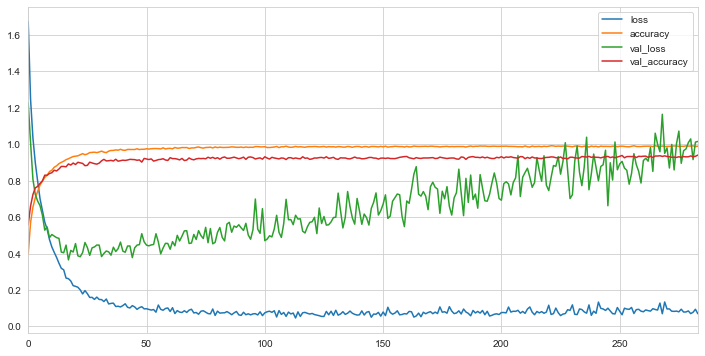

In [22]:
plotHistory(model_4_history)

In [23]:
test_loss, test_acc  = model_4.evaluate(X_test, y_test, batch_size=128)
print(test_loss,test_acc)

8/8 [==============================] - ETA: 0s - loss: 0.7258 - accuracy: 0.94 - 0s 5ms/step - loss: 1.0197 - accuracy: 0.9333
1.019731044769287 0.9332678914070129


# Machine Learning models

In [24]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

In [33]:
def model_assess_2(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_train)
    
    print('Accuracy', title, ':', round(accuracy_score(y_train, preds), 5), '\n')
    
    

def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_dev)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_dev, preds), 5), '\n')
    
def model_assess_1(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(confusion_matrix(y_test, preds))
    print(classification_report(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

# Training accuracy

In [29]:
# Naive Bayes
nb = GaussianNB()
model_assess_2(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess_2(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess_2(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess_2(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess_2(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess_2(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess_2(lg, "Logistic Regression")

# Neural Nets
#nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
#model_assess_2(nn, "Neural Nets")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess_2(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess_2(xgbrf, "Cross Gradient Booster (Random Forest)")

Accuracy Naive Bayes : 0.52796 

Accuracy Stochastic Gradient Descent : 0.68926 

Accuracy KNN : 0.83097 

Accuracy Decission trees : 0.99928 

Accuracy Random Forest : 0.96639 

Accuracy Support Vector Machine : 0.92278 

Accuracy Logistic Regression : 0.74289 

[11:20:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Cross Gradient Booster : 0.99928 

[11:24:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Cross Gradient Booster (Random Forest) : 0.85657 



# Cross validation accuracy

In [31]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

# Neural Nets
#nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
#model_assess(nn, "Neural Nets")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, "Cross Gradient Booster (Random Forest)")


Accuracy Naive Bayes : 0.51668 

Accuracy Stochastic Gradient Descent : 0.66178 

Accuracy KNN : 0.78615 

Accuracy Decission trees : 0.63852 

Accuracy Random Forest : 0.79929 

Accuracy Support Vector Machine : 0.84631 

Accuracy Logistic Regression : 0.71537 

[11:28:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Cross Gradient Booster : 0.90142 

[11:31:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Cross Gradient Booster (Random Forest) : 0.73711 



# Test accuracy

In [34]:
# Naive Bayes
nb = GaussianNB()
model_assess_1(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess_1(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess_1(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess_1(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess_1(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess_1(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess_1(lg, "Logistic Regression")

# Neural Nets
#nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
#model_assess_1(nn, "Neural Nets")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess_1(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess_1(xgbrf, "Cross Gradient Booster (Random Forest)")


[[27  4 22  3  2 10 25  0  5  4]
 [ 0 88  0  0  0  4  0  0  1  8]
 [ 7  4 59  5  1  3 12  4  2  5]
 [ 4  1 13 35  9  0 12 16  2 10]
 [ 8  0  9  9 31  0 12 24  7  2]
 [ 1 25 18  2  1 40  4  0  1 10]
 [ 3  0  3  6  0  0 88  0  1  1]
 [ 0  1  4  7  1  0  0 79  3  7]
 [ 7  0 19  5  7  1  3  6 49  5]
 [ 6  2 16 15  1  0 34  5  3 20]]
              precision    recall  f1-score   support

           0       0.43      0.26      0.33       102
           1       0.70      0.87      0.78       101
           2       0.36      0.58      0.45       102
           3       0.40      0.34      0.37       102
           4       0.58      0.30      0.40       102
           5       0.69      0.39      0.50       102
           6       0.46      0.86      0.60       102
           7       0.59      0.77      0.67       102
           8       0.66      0.48      0.56       102
           9       0.28      0.20      0.23       102

    accuracy                           0.51      1019
   macro avg       